In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv


In [2]:
#  Import and read the data and assign ID column as labels
train = pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv')
test=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv')
subm=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv')


In [3]:
#Drop the non-beneficial ID columns
def set_index (df):
    df.set_index('id', inplace=True)
    return df

train_df=set_index(train)
test_df=set_index(test)
submission_df=set_index(subm)


# Data Exploration

In [4]:
#Determine the number of unique values in each column.
unique_counts = train_df.nunique()
unique_counts

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64

In [5]:
# Checking the datatypes
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [6]:
train_df.shape

(54273, 12)

In [7]:
#Lets look for the total number of NaN values for each feature
train_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


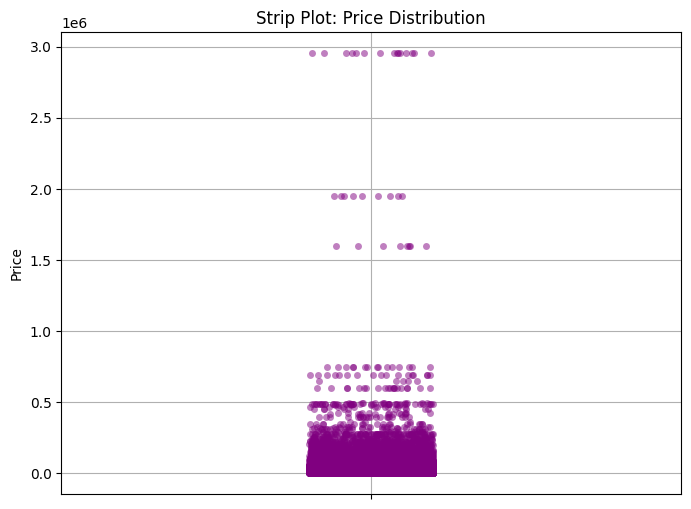

In [8]:
# Create a strip plot for the 'price' variable
plt.figure(figsize=(8, 6))
sns.stripplot(data=train_df, y='price', jitter=True, color='purple', alpha=0.5)
plt.title('Strip Plot: Price Distribution')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Above Histogram shows that most cars lie in the lower range of price.
The above graph has outliers from 0.4 onwards, which need to be removed.

In [9]:
train_df['price'].describe()

count    5.427300e+04
mean     3.921844e+04
std      7.282634e+04
min      2.000000e+03
25%      1.550000e+04
50%      2.800000e+04
75%      4.500000e+04
max      2.954083e+06
Name: price, dtype: float64

In [10]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

29500.0


# **Data wrangling**

I will reduce the number of features in string data categories, and will remain the numeric categories as they are.

In [11]:
#Look at brand value counts for binning
brand_counts = train_df['brand'].value_counts()
brand_counts #keep all car brands 

brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             27
Merc

***Model cleaning***

In [12]:
# Look at model value counts for binning
model_counts =train_df['model'].value_counts()
model_counts

model
F-150 XLT             780
M3 Base               682
X5 xDrive35i          615
F-150 Lariat          496
Mustang GT Premium    466
                     ... 
Suburban 2500           1
TLX Tech                1
Rogue Sport S           1
A8 4.0                  1
S-10 LS                 1
Name: count, Length: 1827, dtype: int64

In [13]:
#Reducing the number of car models as a fuature
cutoff_value = 100 #keep if database has 100 and more records of this car model
model_types_to_replace = model_counts[model_counts < cutoff_value].index

# Replace in the dataframe
for model_c in model_types_to_replace:
    train_df.loc[train_df['model'] == model_c, 'model'] = "Other"

# Check the updated value counts
model_counts = train_df['model'].value_counts()
print(model_counts)

model
Other                   32335
F-150 XLT                 780
M3 Base                   682
X5 xDrive35i              615
F-150 Lariat              496
                        ...  
X6 xDrive35i              101
S-Class S 550 4MATIC      101
Mustang Premium           100
AMG C 63 Base             100
Civic EX                  100
Name: count, Length: 115, dtype: int64


**Fuel cleaning**

In [14]:
# Look at fuel value counts for binning
fuel_counts = train_df['fuel_type'].value_counts()
fuel_counts

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

In [15]:
# Replace '–' with 'Other' in the 'fuel_type' column
train_df.loc[train_df['fuel_type'] == '–', 'fuel_type'] = 'Other'
cleaned_train = train_df[train_df['fuel_type'] != 'not supported']
fuel_counts = cleaned_train['fuel_type'].value_counts()
fuel_counts

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
Other               294
Plug-In Hybrid      182
Name: count, dtype: int64

***Engine cleaning***

In [16]:
# Look at endine value counts for binning
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

engine
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    1452
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             1125
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             1054
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel             979
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel              893
                                                         ... 
4.4 Liter GDI DOHC Twin Turbo                               1
150.0HP 2.0L 4 Cylinder Engine Diesel Fuel                  1
3.0 Liter Twin Turbo                                        1
3.0 Liter SC ULEV                                           1
321.0HP 3.0L V6 Cylinder Engine Gas/Electric Hybrid         1
Name: count, Length: 1059, dtype: int64

In [17]:
cutoff_value = 100
engine_types_to_replace = engine_counts[engine_counts < cutoff_value].index

# Replace in the dataframe
for engine_c in engine_types_to_replace:
    cleaned_train.loc[cleaned_train['engine'] == engine_c, 'engine'] = "Other"

# Check the updated value counts
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

engine
Other                                                    21178
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel     1452
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel              1125
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel              1054
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel              979
                                                         ...  
3.5L V6 24V PDI DOHC                                       104
410.0HP 6.4L 8 Cylinder Engine Gasoline Fuel               103
365.0HP 3.3L V6 Cylinder Engine Gasoline Fuel              100
350.0HP 3.4L Flat 6 Cylinder Engine Gasoline Fuel          100
3.0L V6 24V GDI DOHC Twin Turbo                            100
Name: count, Length: 128, dtype: int64

***Transmission***

In [18]:
# Look at trans value counts for binning
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

transmission
A/T                                                   16754
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6453
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

In [19]:
cutoff_value = 10
trans_types_to_replace = trans_counts[trans_counts < cutoff_value].index

# Replace in the dataframe
for trans_c in trans_types_to_replace:
    cleaned_train.loc[cleaned_train['transmission'] == trans_c, 'transmission'] = "Other"

# Check the updated value counts
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

transmission
A/T                                  16754
8-Speed A/T                           7287
Transmission w/Dual Shift Mode        6453
6-Speed A/T                           5944
6-Speed M/T                           3618
7-Speed A/T                           3415
10-Speed A/T                          2187
8-Speed Automatic                     1189
5-Speed A/T                           1185
9-Speed A/T                           1073
4-Speed A/T                            764
5-Speed M/T                            718
CVT Transmission                       692
10-Speed Automatic                     642
6-Speed Automatic                      516
Automatic                              441
M/T                                    359
9-Speed Automatic                      344
7-Speed Automatic with Auto-Shift      110
7-Speed M/T                            104
Automatic CVT                           95
Other                                   72
1-Speed A/T                             6

***External colour***

In [20]:
# Look at colours value counts for binning
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts.head(50)

ext_col
Black                                 15078
White                                 13422
Gray                                   7908
Silver                                 5158
Blue                                   4668
Red                                    3013
Green                                   763
Gold                                    484
Beige                                   455
Brown                                   386
Orange                                  328
Yellow                                  306
Agate Black Metallic                    113
Bright White Clearcoat                  105
Purple                                   94
Summit White                             88
Black Clearcoat                          83
Diamond Black                            72
Silver Ice Metallic                      62
Delmonico Red Pearlcoat                  56
Soul Red Crystal Metallic                45
–                                        41
Ebony Twilight Metallic 

In [21]:
cutoff_value = 45
ext_col_types_to_replace = ext_col_counts[ext_col_counts < cutoff_value].index

# Replace in the dataframe
for ext_col_c in ext_col_types_to_replace:
    cleaned_train.loc[cleaned_train['ext_col'] == ext_col_c, 'ext_col'] = "Other"

# Check the updated value counts
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts

ext_col
Black                        15078
White                        13422
Gray                          7908
Silver                        5158
Blue                          4668
Red                           3013
Other                         1582
Green                          763
Gold                           484
Beige                          455
Brown                          386
Orange                         328
Yellow                         306
Agate Black Metallic           113
Bright White Clearcoat         105
Purple                          94
Summit White                    88
Black Clearcoat                 83
Diamond Black                   72
Silver Ice Metallic             62
Delmonico Red Pearlcoat         56
Soul Red Crystal Metallic       45
Name: count, dtype: int64

In [22]:
# Look at colours value counts for binning
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts.tail(50)

int_col
Ebony / Pimento              5
Camel                        4
Cocoa / Dune                 4
Dark Gray                    4
Dark Ash                     4
Medium Ash Gray              4
AMG Black                    4
Black / Stone Grey           4
Ash                          4
Walnut                       4
Sport                        3
Nougat Brown                 3
Sand Beige                   3
Almond Beige                 3
Mistral Gray / Raven         3
Rock Gray                    3
Amber                        3
Graystone                    2
Caramel                      2
Tupelo                       2
Very Light Cashmere          2
Pimento Red w/Ebony          2
Medium Pewter                2
Whisper Beige                2
Titan Black                  2
Slate                        2
Cobalt Blue                  2
Silk Beige/Espresso Brown    2
Beluga                       2
Giallo Taurus / Nero Ade     2
Black / Graphite             2
Light Gray                   1


In [23]:
cleaned_train.loc[cleaned_train['int_col'] == '–', 'int_col'] = 'Other'

In [24]:
cutoff_value = 10
int_col_types_to_replace = int_col_counts[int_col_counts < cutoff_value].index

# Replace in the dataframe
for int_col_c in int_col_types_to_replace:
    cleaned_train.loc[cleaned_train['int_col'] == int_col_c, 'int_col'] = "Other"

# Check the updated value counts
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts

int_col
Black                    31818
Beige                     7995
Gray                      6250
Brown                     2239
Red                       1499
Other                     1355
White                     1172
Jet Black                  365
Orange                     248
Ebony                      237
Blue                       212
Silver                     129
Gold                        95
Global Black                58
Green                       56
Medium Stone                39
Black Onyx                  34
Charcoal                    32
Nero Ade                    32
Diesel Gray / Black         30
Rioja Red                   28
Medium Dark Slate           25
White / Brown               22
Portland                    22
Graphite                    22
Medium Earth Gray           21
Tan                         19
Light Slate                 17
Hotspur                     17
Adrenaline Red              17
Shara Beige                 16
Canberra Beige              16


In [25]:
# Determine the cleaned number of unique values in each column.
unique_counts = cleaned_train.nunique()
unique_counts

brand             53
model            115
model_year        34
milage          3212
fuel_type          6
engine           128
transmission      30
ext_col           22
int_col           43
accident           2
clean_title        1
price           1481
dtype: int64

In [26]:
#The last column "Clean_title" is the same "Yes" answer for all rows, that gives no value to analysis. 
#Drop this column.
final_train=cleaned_train.drop(columns=['clean_title'])


In [27]:
# Display the value counts for each column
for column in final_train.columns:
    value_counts = final_train[column].value_counts()
    print(value_counts)


brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2312
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1251
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             27
Merc

***Liner Regression***

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(final_train)
X.shape


(54269, 402)

In [30]:
# Split our preprocessed data into our features and target arrays
y=X['price'].values.reshape(-1, 1)

In [31]:
#Removing the price from the prediction features
X = X.drop(['price'], axis=1)


In [32]:
lm = LinearRegression()
lm.fit(X,y)

LinearRegression()

In [33]:
#make predictions
yhat = lm.predict(X)
yhat[0:5]

array([[49089.09643555],
       [17925.02093506],
       [15693.41137695],
       [79381.78552246],
       [16228.65808105]])

In [34]:
#find the intercept
lm.intercept_

array([-3.8856667e+11])

In [35]:
#find the slope
lm.coef_

array([[ 1.37498991e+03, -1.68339632e-01,  1.77728590e+11,
         1.77728589e+11,  1.77728651e+11,  1.77728599e+11,
         1.77728594e+11,  1.77728631e+11,  1.77730434e+11,
         1.77728584e+11,  1.77728589e+11,  1.77728589e+11,
         1.77728586e+11,  1.77728592e+11,  1.77728568e+11,
         1.77728680e+11,  1.77728589e+11,  1.77728590e+11,
         1.77728592e+11,  1.77728586e+11,  1.77728588e+11,
         1.77728577e+11,  1.77728588e+11,  1.77728594e+11,
         1.77728586e+11,  1.77728580e+11,  1.77728671e+11,
         1.77728596e+11,  1.77728592e+11,  1.77728588e+11,
         1.77728594e+11,  1.77728583e+11,  1.77728579e+11,
         1.77728599e+11,  1.77728621e+11,  1.77728581e+11,
         1.77728637e+11,  1.77728601e+11,  1.77728591e+11,
         1.77728582e+11,  1.77728591e+11,  1.77728553e+11,
         1.77728585e+11,  1.77728610e+11,  1.77728590e+11,
         1.77728610e+11,  1.77728716e+11,  1.77728585e+11,
         1.77728581e+11,  1.77728584e+11,  1.77728577e+1

In [36]:
#find the MSE
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y, yhat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 4606546005.919433


In [37]:
#find the RMSE
rmse = np.sqrt(mse)
rmse

67871.5404710946

In [38]:
#find rscore
from sklearn.metrics import r2_score
r2_score(y, yhat)

0.13148212159271466